# Notebook Setup

### Pre-Import Tasks

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
! pip install --upgrade matplotlib # ONLY run this cell upon intially opening the notebook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.4 MB 33.6 MB/s 
     |████████████████████████████████| 965 kB 64.1 MB/s 
     |████████████████████████████████| 295 kB 78.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [14]:
!cp /content/gdrive/MyDrive/colab_output/project_data_12_21.tar.gz /content/
!cp /content/gdrive/MyDrive/colab_output/project_src_12_21.tar.gz /content/
!tar -xf /content/project_data_12_21.tar.gz
!tar -xf /content/project_src_12_21.tar.gz

In [7]:
%load_ext autoreload

## Imports

In [105]:
import os
import json
from pathlib import Path
import pprint as pp
from glob import glob, iglob
from PIL import Image, ImageFilter, ImageDraw
from typing import List, Union, Tuple, BinaryIO
import shutil

import pickle
import tensorflow as tf
from tensorflow.keras import layers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pycocotools.coco import COCO

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Rectangle, Polygon, Circle

import numpy as np
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

from src.utils.funcs import *
from src.utils.classes import data_generator, CategoricalDataGen
from src.models.layers import CNNBlock

In [29]:
%autoreload 1
%aimport src.utils.funcs
%aimport src.utils.classes
%aimport src.models.layers

In [17]:
pp.PrettyPrinter(indent=4)

# Initializing Data Information

In [18]:
data = init_COCO(["train", "val"])

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 55 val images


In [19]:
train_df = pd.DataFrame(data['train']['annotations'])
train_df['category_id'].value_counts()

6     270
5     269
8     254
7     252
10    250
11    249
12    233
13    232
9     231
3     221
4     220
2     219
1     219
Name: category_id, dtype: int64

# Constructing X and y training sets

```python
X_train = CategoricalDataGen("train", data, "/content/data/images", target_size=(192, 256))
```

```python
batch = X_train.batch(batch_size=16)
for x, y in batch:
    print(x.shape, y.shape)
```

In [22]:
target_size = (192, 256)
validation = CategoricalDataGen("val", data, "/content/data/images", target_size=target_size)
training = CategoricalDataGen("train", data, "/content/data/images", target_size=target_size)

In [23]:
X_train, y_train = np.empty((0, 192, 256, 3), dtype=np.float32), np.empty((0, 13), dtype=np.float32)
X_val, y_val = np.empty((0, 192, 256, 3), dtype=np.float32), np.empty((0, 13), dtype=np.float32)

for x, y in training.batch(batch_size=16):
    X_train = np.append(X_train, x, axis=0)
    y_train = np.append(y_train, y, axis=0)

for x, y in validation.batch(batch_size=16):
    X_val = np.append(X_val, x, axis=0)
    y_val = np.append(y_val, y, axis=0)

In [164]:
def simple_classifier(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.SeparableConv2D(32, 3, activation='relu', padding='same', strides=2)(inputs)
    x = layers.SeparableConv2D(64, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.SeparableConv2D(128, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.SeparableConv2D(256, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.SeparableConv2D(512, 3, activation='relu', strides=2, padding='same')(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(13, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model
     
classifier = simple_classifier((192, 256, 3), 13)
classifier.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d_20 (Separable  (None, 96, 128, 32)  155        ['input_33[0][0]']               
 Conv2D)                                                                                          
                                                                                                  
 separable_conv2d_21 (Separable  (None, 48, 64, 64)  2400        ['separable_conv2d_20[0][0]']    
 Conv2D)                                                                                   

In [165]:
classifier.compile(optimizer='adam',
                   loss=losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [166]:
history = classifier.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


9/9 [==============================] - 2s 92ms/step - loss: 2.4521 - accuracy: 0.1041 - val_loss: 8.2502 - val_accuracy: 0.2182
Epoch 2/50
9/9 [==============================] - 1s 60ms/step - loss: 2.4135 - accuracy: 0.1078 - val_loss: 8.3512 - val_accuracy: 0.0182
Epoch 3/50
9/9 [==============================] - 1s 59ms/step - loss: 2.3830 - accuracy: 0.0223 - val_loss: 8.4863 - val_accuracy: 0.0545
Epoch 4/50
9/9 [==============================] - 1s 60ms/step - loss: 2.3752 - accuracy: 0.0223 - val_loss: 8.5526 - val_accuracy: 0.0545
Epoch 5/50
9/9 [==============================] - 1s 60ms/step - loss: 2.3788 - accuracy: 0.0074 - val_loss: 8.4585 - val_accuracy: 0.0909
Epoch 6/50
9/9 [==============================] - 1s 59ms/step - loss: 2.3735 - accuracy: 0.0074 - val_loss: 8.3933 - val_accuracy: 0.0909
Epoch 7/50
9/9 [==============================] - 1s 60ms/step - loss: 2.3780 - accuracy: 0.2416 - val_loss: 8.5099 - val_accuracy: 0.2182
Epoch 8/50
9/9 [======================

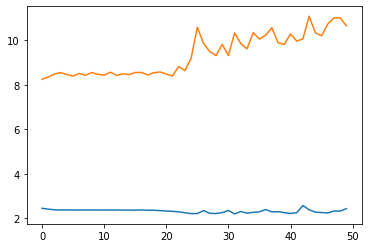

In [167]:
fig, ax = plt.pyplot.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])

In [154]:
preds = classifier.predict(X_val[:20])

1/1 [==============================] - 0s 108ms/step


In [155]:
print(y_val[:3],"\n", preds[:3])

[[0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1.]] 
 [[0.11709909 0.10690407 0.12358815 0.13259469 0.11303666 0.12437276
  0.11307201 0.12455273 0.0088567  0.00906668 0.0083884  0.0080873
  0.00592987]
 [0.13533914 0.10530239 0.13280909 0.11882445 0.11338406 0.10828715
  0.11850473 0.11795162 0.02468243 0.02782483 0.03470737 0.02153925
  0.0319065 ]
 [0.12063749 0.09289061 0.12475853 0.1003157  0.10344582 0.09357949
  0.10950865 0.10342821 0.01993318 0.02204906 0.02019766 0.01686893
  0.01668625]]
